### XGBoost Model Application

#### useful link
https://machinelearningmastery.com/xgboost-for-time-series-forecasting/


 Processing Scenario 4
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters Found:
{'colsample_bytree': 0.6523068845866853, 'gamma': 0.029301634201915158, 'learning_rate': 0.21526990795364706, 'max_depth': 5, 'n_estimators': 287, 'reg_alpha': 0.12203823484477883, 'reg_lambda': 5.951769101112702, 'subsample': 0.5171942605576092}
Scenario 4 - Train - RMSE: 13.74, MAE: 10.36, R²: 0.84, NSE: 0.84


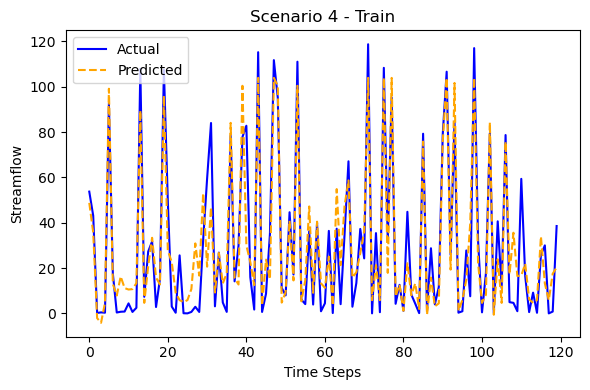

Scenario 4 - Validation - RMSE: 16.41, MAE: 11.85, R²: 0.81, NSE: 0.81


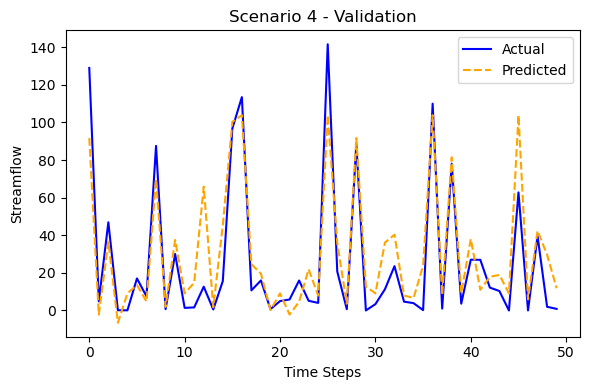

Scenario 4 - Test - RMSE: 20.21, MAE: 14.73, R²: 0.78, NSE: 0.78


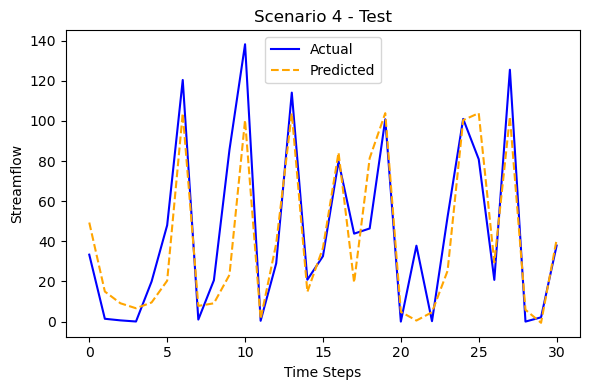


 Processing Scenario 5
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters Found:
{'colsample_bytree': 0.7699205456508366, 'gamma': 0.060918367420430816, 'learning_rate': 0.2928560711673943, 'max_depth': 5, 'n_estimators': 286, 'reg_alpha': 0.6947849330397046, 'reg_lambda': 9.804678390152578, 'subsample': 0.8121770240668966}
Scenario 5 - Train - RMSE: 14.30, MAE: 11.16, R²: 0.83, NSE: 0.83


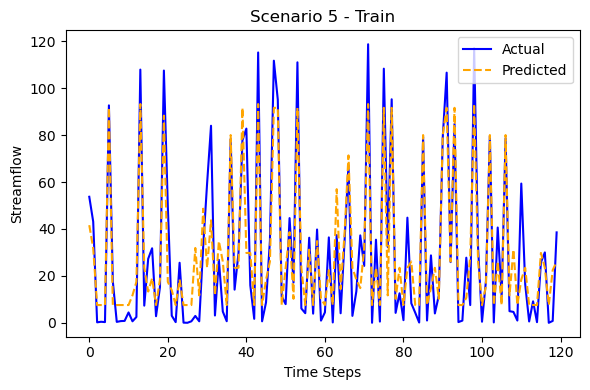

Scenario 5 - Validation - RMSE: 17.11, MAE: 12.29, R²: 0.80, NSE: 0.80


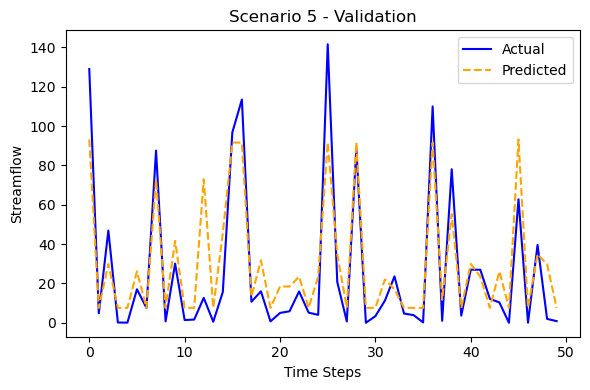

Scenario 5 - Test - RMSE: 20.40, MAE: 14.82, R²: 0.77, NSE: 0.77


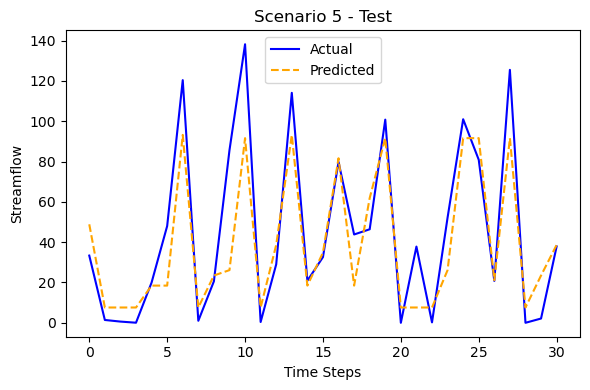

In [1]:

# Import essential libraries for data handling, visualization, and modeling
import os  # For creating folders and saving plots
import pandas as pd  # For reading and manipulating data tables
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting graphs
from sklearn.preprocessing import MinMaxScaler  # For scaling data to a common range
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # For evaluating model accuracy
from sklearn.model_selection import train_test_split, RandomizedSearchCV  # For splitting data and tuning model
from xgboost import XGBRegressor  # XGBoost model for regression tasks
from scipy.stats import uniform, randint  # For defining random search ranges

# Define a function to calculate model performance using Nash-Sutcliffe Efficiency
def nash_sutcliffe_efficiency(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

# Define a function to evaluate and visualize model predictions
def evaluate_and_plot(y_true, y_pred, title):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)) # Root Mean Square Error
    mae = mean_absolute_error(y_true, y_pred)  # Mean Absolute Error
    r2 = r2_score(y_true, y_pred) # Coefficient of Determination 
    nse = nash_sutcliffe_efficiency(y_true, y_pred) # Nash-Sutcliffe Efficiency 
    
    # Print performance results 
    print(f"{title} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}, NSE: {nse:.2f}")

    # Plot actual vs. predicted values 
    plt.figure(figsize=(6, 4))
    plt.plot(y_true, label='Actual', color='blue')  
    plt.plot(y_pred, label='Predicted', color='orange', linestyle='--')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Streamflow')
    plt.legend()
    plt.tight_layout()

    # Save the plot in a directory folder
    os.makedirs('XGBoost_Visuals', exist_ok=True)
    filename = f"{title.replace(' ', '_').replace('-', '')}.png"
    plt.savefig(os.path.join('XGBoost_Visuals', filename))
    plt.show()

# Define utilized scenario datasets
scenario_files = {
    'Scenario 4': 'cleaned_processed_data_scenario4.csv',
    'Scenario 5': 'cleaned_processed_data_scenario5.csv',
}

# Loop through each scenario to train and evaluate the model
for scenario_name, filename in scenario_files.items():
    print(f"\n Processing {scenario_name}")

    # Load dataset
    df = pd.read_csv(filename)  
    df = df.drop(columns=['Date']) # drop Date column as is not needed for modelling 

    # Split into features (X) and target (y)
    X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values

    # Split data into 60% train, 25% validation, 15% test
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2941, random_state=42)

    
    # MinMaxScaler transforms data to a range between 0 and 1 - helps the model learn more efficiently and reduces bias from large values
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Fit scalers on training data only
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

    # Transform validation and test data using training scalers
    X_val_scaled = scaler_X.transform(X_val)
    y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).ravel()
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()


    # Define ranges for hyperparameter tuning using random search
    param_dist = {
        'n_estimators': randint(100, 300),
        'max_depth': randint(3, 7),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5),
        'gamma': uniform(0, 0.3),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(1, 10)
    }

    # Initialize XGBoost model and perform hyperparameter tuning
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_dist,
        n_iter=50,
        scoring='r2',
        cv=5,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    random_search.fit(X_train_scaled, y_train_scaled)  # se scaled data

    # Retrieve and display the best parameters found
    best_params = random_search.best_params_
    print("Best Parameters Found:")
    print(best_params)

    # Train final model using the best parameters
    final_model = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
    final_model.fit(X_train_scaled, y_train_scaled)

    # Make predictions and convert them back to original scale
    y_train_pred = scaler_y.inverse_transform(final_model.predict(X_train_scaled).reshape(-1, 1))
    y_val_pred = scaler_y.inverse_transform(final_model.predict(X_val_scaled).reshape(-1, 1))
    y_test_pred = scaler_y.inverse_transform(final_model.predict(X_test_scaled).reshape(-1, 1))

    y_train_true = scaler_y.inverse_transform(y_train_scaled.reshape(-1, 1))
    y_val_true = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1))
    y_test_true = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))

    # Evaluate and visualize model performance
    evaluate_and_plot(y_train_true, y_train_pred, f"{scenario_name} - Train")
    evaluate_and_plot(y_val_true, y_val_pred, f"{scenario_name} - Validation")
    evaluate_and_plot(y_test_true, y_test_pred, f"{scenario_name} - Test")